In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


In [13]:
def assign_priority_fuzzy_sigmoid_robust(row,
                                         expiry_threshold=120,
                                         delivery_threshold=10,
                                         high_cutoff=0.6,
                                         medium_cutoff=0.4,
                                         weights=None,
                                         k=0.08):
    if weights is None:
        weights = {
            'expiry': 0.4,
            'delivery': 0.3,
            'urgent': 0.2,
            'temp': 0.05,
            'fragile': 0.05
        }

    expiry_days = row['Expiry_Days_Left']
    delivery_days = row['Delivery_Window_Days']

    expiry_score = 1 / (1 + np.exp(k * (expiry_days - expiry_threshold)))
    delivery_score = 1 / (1 + np.exp(k * (delivery_days - delivery_threshold)))

    urgent_score = 1 if row['Urgent_Order_Flag'] == 'Yes' else 0
    temp_score = 1 if row['Temp_Sensitive'] == 'Yes' else 0
    fragile_score = 1 if row['Fragility'] == 'Yes' else 0

    if expiry_days <= 30 and row['Urgent_Order_Flag'] == 'Yes':
        return 'High'
    if expiry_days <= 30 and row['Temp_Sensitive'] == 'Yes':
        return 'High'
    if delivery_days <= 5 and row['Urgent_Order_Flag'] == 'Yes':
        return 'High'
    if expiry_days <= 10 and delivery_days <= 5:
        return 'High'
    if row['Urgent_Order_Flag'] == 'Yes' and row['Fragility'] == 'Yes':
        return 'High'
    if expiry_days > 600 and delivery_days > 45 and row['Urgent_Order_Flag'] == 'No':
        return 'Low'

    total_score = (
        expiry_score * weights['expiry'] +
        delivery_score * weights['delivery'] +
        urgent_score * weights['urgent'] +
        temp_score * weights['temp'] +
        fragile_score * weights['fragile']
    )

    if total_score >= high_cutoff:
        return 'High'
    elif total_score >= medium_cutoff:
        return 'Medium'
    else:
        return 'Low'


In [15]:
# Load your full dataset (6000+ rows)
main_set = r"C:\Users\Administrator\Desktop\Python\ML\ProjectPlan\clustered_with_vehicle_assignments_final.csv"
df = pd.read_csv(main_set)

# Rename to match fuzzy logic keys
df.rename(columns={
    'Urgent_Flag': 'Urgent_Order_Flag',
    'Temp_Sensitive_Flag': 'Temp_Sensitive',
    'Fragile_Flag': 'Fragility'
}, inplace=True)

# Convert Flags from 1/0 → 'Yes'/'No'
for col in ['Urgent_Order_Flag', 'Temp_Sensitive', 'Fragility']:
    df[col] = df[col].replace({1: 'Yes', 0: 'No'})


In [20]:
  # Your main assignment dataset

product_dataset = r"C:\Users\Administrator\Desktop\Python\ML\DataSets\RawDataSets\products\products.csv"
products_df = pd.read_csv(product_dataset)        # Product master with Expiry_Date
# Load both datasets
df = pd.read_csv(main_set)  # your main dataframe
products_df = pd.read_csv(product_dataset)  # has 'Product_ID' and 'Expiry_Date'

# Check required columns
assert 'Product_ID' in df.columns, "Product_ID missing in main dataset"
assert 'Product_ID' in products_df.columns, "Product_ID missing in product dataset"
assert 'Expiry_Date' in products_df.columns, "Expiry_Date missing in product dataset"

# Convert date columns to datetime
df['Dispatch_Window'] = pd.to_datetime(df['Dispatch_Window'], errors='coerce')
df['Delivery_Window'] = pd.to_datetime(df['Delivery_Window'], errors='coerce')
products_df['Expiry_Date'] = pd.to_datetime(products_df['Expiry_Date'], errors='coerce')

# Merge Expiry_Date into main df using Product_ID
df = df.merge(products_df[['Product_ID', 'Expiry_Date']], on='Product_ID', how='left')

# Calculate derived columns
today = pd.Timestamp.today().normalize()
df['Delivery_Window_Days'] = (df['Delivery_Window'] - df['Dispatch_Window']).dt.days
df['Expiry_Days_Left'] = (df['Expiry_Date'] - today).dt.days

# Drop rows with invalid dates
df.dropna(subset=['Dispatch_Window', 'Delivery_Window', 'Expiry_Date'], inplace=True)

# Preview
df[['Product_ID', 'Expiry_Date', 'Expiry_Days_Left']].head()


,Product_ID,Expiry_Date,Expiry_Days_Left
0,TOP-1005-B43-854,2026-01-10,188
1,TOP-1005-B43-854,2026-01-10,188
2,TOP-1005-B43-854,2026-01-10,188
3,TOP-1005-B43-854,2026-01-10,188
4,TOP-1005-B43-854,2026-01-10,188


In [21]:
# Convert dispatch/delivery/expiry columns
df['Dispatch_Window'] = pd.to_datetime(df['Dispatch_Window'], errors='coerce')
df['Delivery_Window'] = pd.to_datetime(df['Delivery_Window'], errors='coerce')
df['Expiry_Date'] = pd.to_datetime(df['Expiry_Date'], errors='coerce')

today = pd.Timestamp.today().normalize()

df['Delivery_Window_Days'] = (df['Delivery_Window'] - df['Dispatch_Window']).dt.days
df['Expiry_Days_Left'] = (df['Expiry_Date'] - today).dt.days

# Drop rows with bad dates
df.dropna(subset=['Dispatch_Window', 'Delivery_Window', 'Expiry_Date'], inplace=True)


In [23]:
# 🔄 Rename columns to match fuzzy logic function input
df.rename(columns={
    'Urgent_Flag': 'Urgent_Order_Flag',
    'Temp_Sensitive_Flag': 'Temp_Sensitive',
    'Fragile_Flag': 'Fragility'
}, inplace=True)

# 🔁 Convert binary to 'Yes'/'No' as required by fuzzy logic
df['Urgent_Order_Flag'] = df['Urgent_Order_Flag'].map({1: 'Yes', 0: 'No'})
df['Temp_Sensitive'] = df['Temp_Sensitive'].map({1: 'Yes', 0: 'No'})
df['Fragility'] = df['Fragility'].map({1: 'Yes', 0: 'No'})


In [24]:
df['Priority_Label'] = df.apply(assign_priority_fuzzy_sigmoid_robust, axis=1)

print(df['Priority_Label'].value_counts())


Priority_Label
High      155424
Low        33948
Medium      7812
Name: count, dtype: int64


In [25]:
# Binary encode flags again for ML input
df['Urgent_Order_Flag'] = df['Urgent_Order_Flag'].map({'Yes': 1, 'No': 0})
df['Temp_Sensitive'] = df['Temp_Sensitive'].map({'Yes': 1, 'No': 0})
df['Fragility'] = df['Fragility'].map({'Yes': 1, 'No': 0})

features = [
    'Expiry_Days_Left',
    'Delivery_Window_Days',
    'Urgent_Order_Flag',
    'Temp_Sensitive',
    'Fragility'
]

# Encode target
le = LabelEncoder()
df['Priority_Label_Encoded'] = le.fit_transform(df['Priority_Label'])


In [26]:
X = df[features]
y = df['Priority_Label_Encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, n_estimators=150, random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     31085
           1       1.00      1.00      1.00      6790
           2       1.00      1.00      1.00      1562

    accuracy                           1.00     39437
   macro avg       1.00      1.00      1.00     39437
weighted avg       1.00      1.00      1.00     39437



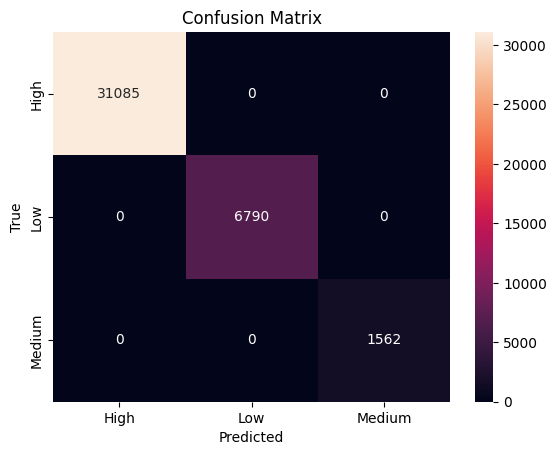

In [27]:
y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [28]:
with open("priority_model.pkl", "wb") as f:
    pickle.dump(clf, f)

with open("priority_label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("✅ Model & LabelEncoder saved successfully.")


✅ Model & LabelEncoder saved successfully.


In [29]:
import pandas as pd
import pickle

# -------------------------------
# ✅ Step 1: Sample Input Data (Simulated)
# -------------------------------
sample_inputs = [
    {
        "Expiry_Days_Left": 15,
        "Delivery_Window_Days": 3,
        "Urgent_Order_Flag": 1,
        "Temp_Sensitive": 1,
        "Fragility": 0
    },
    {
        "Expiry_Days_Left": 300,
        "Delivery_Window_Days": 20,
        "Urgent_Order_Flag": 0,
        "Temp_Sensitive": 0,
        "Fragility": 1
    },
    {
        "Expiry_Days_Left": 5,
        "Delivery_Window_Days": 2,
        "Urgent_Order_Flag": 1,
        "Temp_Sensitive": 0,
        "Fragility": 1
    },
    {
        "Expiry_Days_Left": 700,
        "Delivery_Window_Days": 60,
        "Urgent_Order_Flag": 0,
        "Temp_Sensitive": 0,
        "Fragility": 0
    }
]

# -------------------------------
# ✅ Step 2: Convert to DataFrame
# -------------------------------
input_df = pd.DataFrame(sample_inputs)

# Ensure all required columns exist
required_cols = ['Expiry_Days_Left', 'Delivery_Window_Days', 'Urgent_Order_Flag', 'Temp_Sensitive', 'Fragility']
assert all(col in input_df.columns for col in required_cols), "Missing input columns"

# -------------------------------
# ✅ Step 3: Load Trained Model and Label Encoder
# -------------------------------
with open("priority_model.pkl", "rb") as f:
    clf = pickle.load(f)

with open("priority_label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# -------------------------------
# ✅ Step 4: Predict Priorities
# -------------------------------
pred_encoded = clf.predict(input_df)
pred_labels = le.inverse_transform(pred_encoded)

# -------------------------------
# ✅ Step 5: Attach Result to DataFrame
# -------------------------------
input_df['Predicted_Priority'] = pred_labels

# Output results
print(input_df)


   Expiry_Days_Left  Delivery_Window_Days  Urgent_Order_Flag  Temp_Sensitive  \
0                15                     3                  1               1   
1               300                    20                  0               0   
2                 5                     2                  1               0   
3               700                    60                  0               0   

   Fragility Predicted_Priority  
0          0               High  
1          1                Low  
2          1               High  
3          0                Low  
